In [2]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [4]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [5]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [7]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [8]:
def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        #albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

In [9]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [11]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [18]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias']
Y

device(type='cuda', index=0)

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"], downsampled_labels)
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [20]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze(0)

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-base-batchsize8-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [21]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = smp.losses.FocalLoss(mode="multiclass")
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:02<00:00,  1.14it/s]


Epoch: 1, Loss: 0.1305654229506129


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.37it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.029624 | F1-Score: 11.72% | IoU: 8.27% | Precision: 28.11% | Recall: 9.55% | Accuracy: 98.38%
Model saved at 1 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 2, Loss: 0.027791395241154298


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:07<00:00,  1.32it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.022745 | F1-Score: 29.99% | IoU: 20.36% | Precision: 53.31% | Recall: 24.62% | Accuracy: 98.52%
Model saved at 2 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:08<00:00,  1.13it/s]


Epoch: 3, Loss: 0.022721382272579978


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.020053 | F1-Score: 37.10% | IoU: 24.73% | Precision: 74.57% | Recall: 28.18% | Accuracy: 98.57%
Model saved at 3 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 4, Loss: 0.020565765074664545


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:05<00:00,  1.35it/s]


Validation: Loss: 0.018764 | F1-Score: 49.30% | IoU: 34.03% | Precision: 68.95% | Recall: 41.55% | Accuracy: 98.62%
Model saved at 4 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:06<00:00,  1.13it/s]


Epoch: 5, Loss: 0.01932340023077784


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.017898 | F1-Score: 50.86% | IoU: 35.34% | Precision: 70.39% | Recall: 42.15% | Accuracy: 98.65%
Model saved at 5 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:05<00:00,  1.14it/s]


Epoch: 6, Loss: 0.018704599933698773


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.017459 | F1-Score: 57.54% | IoU: 41.08% | Precision: 69.00% | Recall: 51.09% | Accuracy: 98.67%
Model saved at 6 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:04<00:00,  1.14it/s]


Epoch: 7, Loss: 0.018077827410231676


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.017221 | F1-Score: 59.37% | IoU: 42.59% | Precision: 67.07% | Recall: 54.03% | Accuracy: 98.68%
Model saved at 7 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 8, Loss: 0.0178101671769494


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:07<00:00,  1.32it/s]


Validation: Loss: 0.017057 | F1-Score: 61.87% | IoU: 45.09% | Precision: 67.08% | Recall: 57.95% | Accuracy: 98.68%
Model saved at 8 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:08<00:00,  1.13it/s]


Epoch: 9, Loss: 0.017285718903275987


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.017202 | F1-Score: 60.29% | IoU: 43.46% | Precision: 68.78% | Recall: 54.00% | Accuracy: 98.68%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:06<00:00,  1.13it/s]


Epoch: 10, Loss: 0.01691826971157664


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016625 | F1-Score: 62.81% | IoU: 46.00% | Precision: 68.50% | Recall: 58.32% | Accuracy: 98.72%
Model saved at 10 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:05<00:00,  1.14it/s]


Epoch: 11, Loss: 0.01661112915814644


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016524 | F1-Score: 60.18% | IoU: 43.41% | Precision: 70.32% | Recall: 53.20% | Accuracy: 98.71%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:05<00:00,  1.14it/s]


Epoch: 12, Loss: 0.016296132807920298


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.016620 | F1-Score: 63.03% | IoU: 46.27% | Precision: 69.34% | Recall: 58.05% | Accuracy: 98.72%
Model saved at 12 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:08<00:00,  1.13it/s]


Epoch: 13, Loss: 0.015981553639135053


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.016448 | F1-Score: 60.61% | IoU: 43.88% | Precision: 71.87% | Recall: 53.14% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 14, Loss: 0.015792804086701043


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.35it/s]


Validation: Loss: 0.016948 | F1-Score: 63.21% | IoU: 46.38% | Precision: 67.69% | Recall: 59.51% | Accuracy: 98.73%
Model saved at 14 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:06<00:00,  1.13it/s]


Epoch: 15, Loss: 0.015588259947816692


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.016471 | F1-Score: 62.65% | IoU: 45.84% | Precision: 71.93% | Recall: 55.82% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 16, Loss: 0.015424405439801874


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016554 | F1-Score: 65.40% | IoU: 48.75% | Precision: 68.78% | Recall: 62.80% | Accuracy: 98.75%
Model saved at 16 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 17, Loss: 0.01517923012030341


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.016977 | F1-Score: 64.57% | IoU: 47.81% | Precision: 69.38% | Recall: 60.42% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 18, Loss: 0.01492477878209977


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016547 | F1-Score: 65.45% | IoU: 48.82% | Precision: 69.98% | Recall: 61.80% | Accuracy: 98.73%
Model saved at 18 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:07<00:00,  1.13it/s]


Epoch: 19, Loss: 0.01469805126994728


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:07<00:00,  1.33it/s]


Validation: Loss: 0.017980 | F1-Score: 63.29% | IoU: 46.52% | Precision: 71.70% | Recall: 56.99% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:09<00:00,  1.13it/s]


Epoch: 20, Loss: 0.01481841779013555


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:07<00:00,  1.33it/s]


Validation: Loss: 0.017567 | F1-Score: 59.20% | IoU: 42.64% | Precision: 74.31% | Recall: 50.49% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:37<00:00,  1.07it/s]


Epoch: 21, Loss: 0.014660683362143895


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.25it/s]


Validation: Loss: 0.016903 | F1-Score: 63.51% | IoU: 46.98% | Precision: 69.42% | Recall: 59.91% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:38<00:00,  1.07it/s]


Epoch: 22, Loss: 0.014610041029781343


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.26it/s]


Validation: Loss: 0.019341 | F1-Score: 49.94% | IoU: 34.35% | Precision: 76.88% | Recall: 39.07% | Accuracy: 98.70%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:35<00:00,  1.08it/s]


Epoch: 23, Loss: 0.014326291912866216


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.27it/s]


Validation: Loss: 0.018709 | F1-Score: 55.15% | IoU: 38.64% | Precision: 76.65% | Recall: 44.18% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:39<00:00,  1.07it/s]


Epoch: 24, Loss: 0.014289403322993988


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.26it/s]


Validation: Loss: 0.018978 | F1-Score: 59.00% | IoU: 42.23% | Precision: 75.07% | Recall: 49.28% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:39<00:00,  1.07it/s]


Epoch: 25, Loss: 0.014435768097398742


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.25it/s]


Validation: Loss: 0.018650 | F1-Score: 64.24% | IoU: 47.77% | Precision: 61.80% | Recall: 69.44% | Accuracy: 98.54%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:36<00:00,  1.07it/s]


Epoch: 26, Loss: 0.01436872685237998


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.26it/s]


Validation: Loss: 0.018998 | F1-Score: 57.65% | IoU: 41.08% | Precision: 75.33% | Recall: 48.09% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:39<00:00,  1.07it/s]


Epoch: 27, Loss: 0.014202034341982537


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.27it/s]


Validation: Loss: 0.021696 | F1-Score: 52.09% | IoU: 35.72% | Precision: 75.24% | Recall: 41.01% | Accuracy: 98.62%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:35<00:00,  1.08it/s]


Epoch: 28, Loss: 0.014479683595709503


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.17it/s]


Validation: Loss: 0.023862 | F1-Score: 45.70% | IoU: 30.93% | Precision: 79.04% | Recall: 34.48% | Accuracy: 98.65%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:36<00:00,  1.08it/s]


Epoch: 29, Loss: 0.014163646367453639


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.26it/s]


Validation: Loss: 0.028596 | F1-Score: 29.06% | IoU: 19.26% | Precision: 79.71% | Recall: 22.56% | Accuracy: 98.59%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:38<00:00,  1.07it/s]


Epoch: 30, Loss: 0.014251316278692215


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.174443 | F1-Score: 0.27% | IoU: 0.14% | Precision: 33.40% | Recall: 0.14% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:35<00:00,  1.08it/s]


Epoch: 31, Loss: 0.014769885441168182


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.091436 | F1-Score: 2.36% | IoU: 1.20% | Precision: 68.90% | Recall: 1.21% | Accuracy: 97.83%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:37<00:00,  1.07it/s]


Epoch: 32, Loss: 0.014956797767550715


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.26it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.109184 | F1-Score: 0.00% | IoU: 0.00% | Precision: 20.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:38<00:00,  1.07it/s]


Epoch: 33, Loss: 0.014272708382697835


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:10<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.054713 | F1-Score: 8.14% | IoU: 5.09% | Precision: 52.99% | Recall: 5.30% | Accuracy: 98.19%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:35<00:00,  1.08it/s]


Epoch: 34, Loss: 0.014489824472806386


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.347954 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:38<00:00,  1.07it/s]


Epoch: 35, Loss: 0.014613005417894813


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.250473 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:37<00:00,  1.07it/s]


Epoch: 36, Loss: 0.015249432704501575


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.27it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.081857 | F1-Score: 0.13% | IoU: 0.07% | Precision: 18.10% | Recall: 0.07% | Accuracy: 97.79%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:35<00:00,  1.08it/s]


Epoch: 37, Loss: 0.014411307032400322


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.28it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.466723 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:38<00:00,  1.07it/s]


Epoch: 38, Loss: 0.014485557557218857


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.25it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.598995 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:40<00:00,  1.07it/s]


Epoch: 39, Loss: 0.014835963946496767


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:11<00:00,  1.25it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 1.282120 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [09:40<00:00,  1.07it/s]


Epoch: 40, Loss: 0.01536252245367054


 87%|██████████████████████████████████████████████████████████████████████▉           | 77/89 [01:02<00:09,  1.24it/s]


KeyboardInterrupt: 

In [22]:
best_model = torch.load('model-base-batchsize8-2024-06-20.pt')
best_model = best_model.to(device)

In [23]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:36<00:00,  1.22it/s]


In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.723295,0.566532,0.721868,0.724727
2,0.667861,0.501345,0.665545,0.670193
3,0.691904,0.528940,0.712613,0.672365
4,0.638713,0.469198,0.751901,0.555144
5,0.636920,0.467265,0.685506,0.594765


In [25]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 67.17%
IoU: 50.67%
Precision: 70.75%
Recall: 64.34%
Overall Accuracy: 98.75%


In [26]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

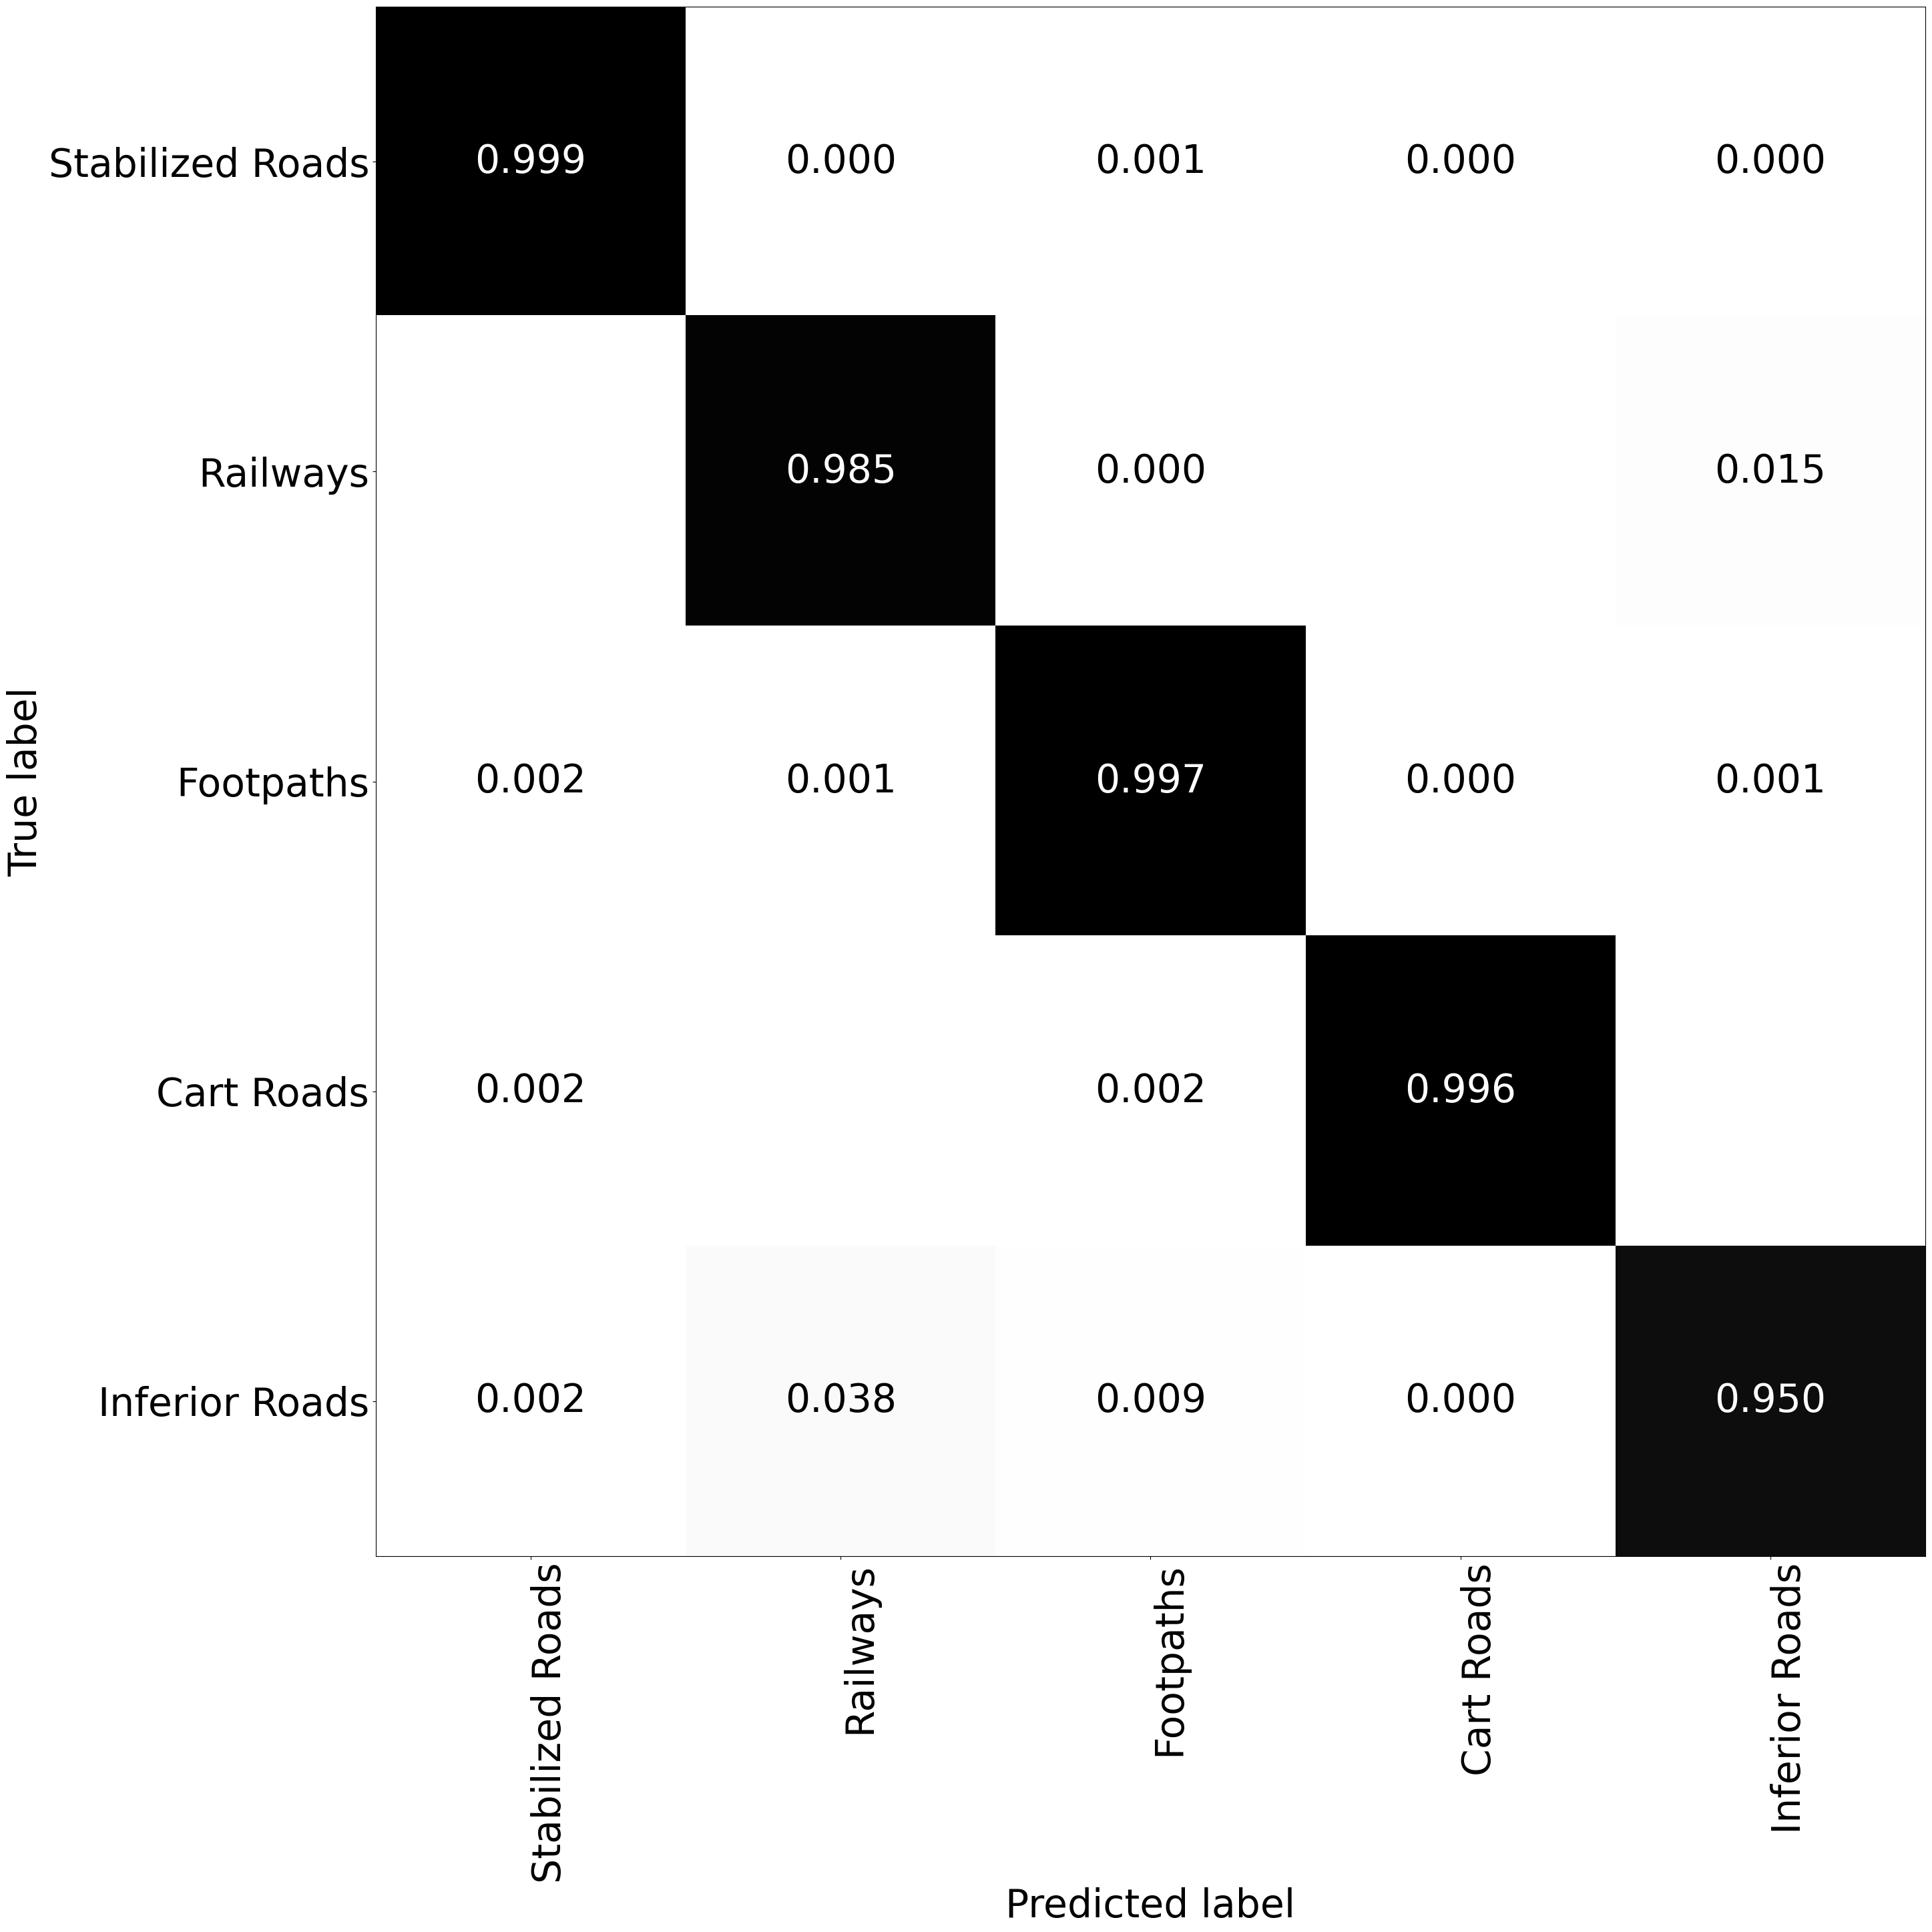

In [28]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [23]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


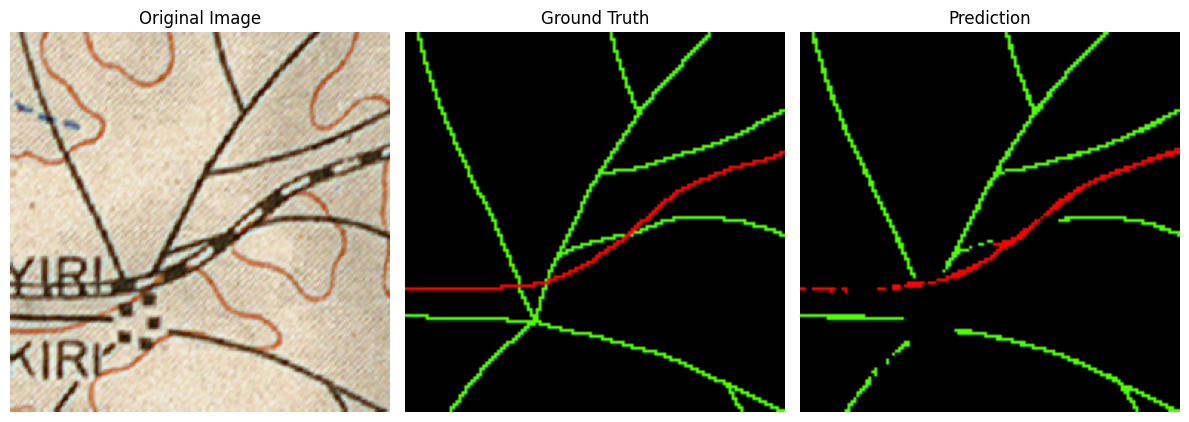

In [34]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
